**извлечение признаков из текста на естественном языке**

кластеризатор текстов   
  CountVectorizer + KMeans

_Евгений Борисов <esborisov@sevsu.ru>_

## библиотеки

In [1]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm.notebook import tqdm

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

In [2]:
from sklearn import __version__ as SKLEARN_VERSION

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

SKLEARN_VERSION

'1.0.2'

## тексты

In [3]:
# загружаем тексты
data = pd.read_pickle('../data/text/news.pkl.gz')
print('записей:',len(data))

записей: 3196


In [4]:
data.sample(2)

,text,tag
2670,"Американские нейробиологи из Висконсинского университета в Мэдисоне решили узнать, что происходит с мозгом в режиме многозадачности. Увиденное их поразило.\r\n\r\nОказалось, он в буквальном смысле...",science
1194,Минчане пожаловались в прокуратуру на администрацию Советского района\n\n28 ноября 2016 в 14:29\n\nЕлена Толкачева / REALTY.TUT.BY\n\nИнициативная группа жителей Советского района направила в райо...,realty


## токенизация и очистка

In [5]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords

# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def string_normalizer(s):
    pat = [
       [r'ё','е'] # замена ё для унификации
       ,[r'</?[a-z]+>',' '] # удаляем xml
       ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
       ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
       ,[r'\w+- ',' ']
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()

In [6]:
data['ctext'] = data['text'].progress_apply(string_normalizer)

  0%|          | 0/3196 [00:00<?, ?it/s]

##  Vectorizer

In [7]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus        import stopwords        as nltk_stopwords

stopwords = set(nltk_stopwords.words('russian'))
stemmer = SnowballStemmer('russian')

# разрезаем стоки на слова, выкидываем stopwords, выполняем стеминг
def tokenizer_stemmer(s,stemmer=stemmer,stopwords=stopwords): 
    for w in s.split(' '):
        o = stemmer.stem(w).replace('^','')
        if len(o)<2: continue
        if o in stopwords: continue
        yield o 


# def tokenizer(s): 
#     for w in s.split(' '):
#         if (len(w)>1): 
#             yield w        

In [8]:
%%time 

X = CountVectorizer(tokenizer=tokenizer_stemmer, token_pattern=None).fit_transform(data['ctext'])

CPU times: user 1min 18s, sys: 80.1 ms, total: 1min 18s
Wall time: 1min 19s


## кластеризируем

In [19]:
%%time 

n_clusters=55

data['cluster'] = KMeans(n_clusters=n_clusters).fit(X).labels_
data['cluster'].drop_duplicates().count()

CPU times: user 31.7 s, sys: 418 ms, total: 32.1 s
Wall time: 28.9 s


55

## тестируем

In [ ]:
# номер кластера, количество объектов, метки объектов
# (cluster=-1 - некластеризованные DBSCAN объекты)
cluster_descr = pd.concat([
        data[['cluster','tag']].groupby(['cluster'])['tag'].count(),
        data[['cluster','tag']].groupby(['cluster'])['tag'].apply(lambda s: set(s)).apply(' '.join)
    ],axis=1).reset_index()

cluster_descr.columns = ['cluster','count','tags']

In [24]:
cluster_descr.query('count>1')

,cluster,count,tags
0,0,4,tech science politics
1,1,30,incident auto
2,2,353,social culture auto science woman economics realty reclama incident politics tech sport
4,4,112,social culture science woman economics realty reclama tech politics auto sport
5,5,122,politics economics
16,16,2447,social culture auto science woman health economics incident reclama realty sport tech politics
19,19,4,reclama culture tech
20,20,2,culture
26,26,5,sport culture woman auto
27,27,2,woman


<AxesSubplot:xlabel='cluster'>

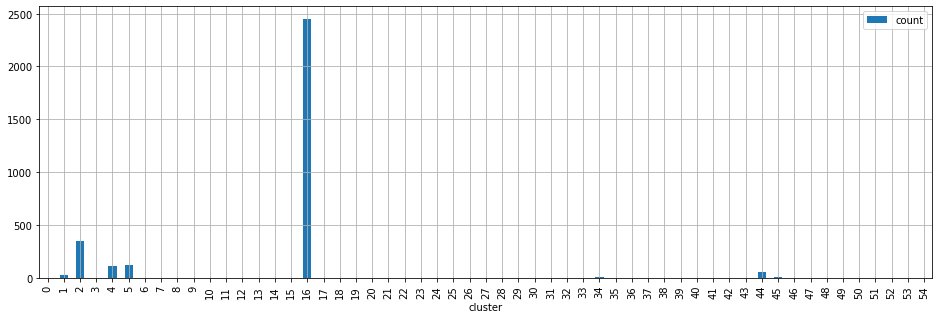

In [21]:
# размеры кластеров
cluster_descr[['cluster','count']]\
    .query('cluster>-1')\
    .set_index('cluster')\
    .plot.bar(grid=True,figsize=(16,5))

In [22]:
def print_cluster_samples(n,ns=3,nt=512):
    count,tags = cluster_descr.query(f'cluster=={n}')[['count','tags']].values[0]#.tolist
    df = data.query(f'cluster=={n}')
    ns_ = min(ns,len(df))
    top = [ t[:nt].replace('\n',' ') for t in df['text'].sample(ns_).values ]
    print('[ КЛАСТЕР %i, элементов: %i, метки: "%s" ]'%(n,count,tags))
    for s in top: print('\n%s ...\n'%(s) )

In [23]:
for n in rng.permutation(cluster_descr.query('count>1')['cluster'].values)[:3] :
    print_cluster_samples(n)
    print('\n= = = = = = = = = = = = = = = = = = = = = = = = = =\n')

[ КЛАСТЕР 19, элементов: 4, метки: "reclama culture tech" ]

Объявлены обладатели "игрового Оскара"  2 декабря 2016 в 9:54  Александр Михно, 42.TUT.BY  В Лос-Анджелесе в третий раз прошла ежегодная церемония награждения The Game Awards 2016. На основании пользовательского голосования были выбраны самые лучшие игры уходящего года в нескольких номинациях. С победителями можно не согласиться (некоторые игры действительно находятся не на своем месте), но когда результаты голосования в интернете совпадали с вашим мнением?  Победители  В 2016 году список победителей The Ga ...


"Я хочу платить актерам зарплату". Проблемы белорусского кино глазами режиссера Влады Сеньковой  29 ноября 2016 в 13:03  Анна Ефременко / Фото: Дмитрий Брушко / AFISHA.TUT.BY  «Летом в Берлине от голода у меня как-то раз даже случилась галлюцинация. Мы тогда ездили с промо Ahaha по Европе и собирали деньги на фильм». Но то было летом. Сейчас режиссер и сценарист Влада Сенькова ищет деньги на новый проект по-взрослому